# Ensemble Learning for Breast Cancer Classification

This notebook applies ensemble learning methods (bagging, boosting, and stacking) to classify breast cancer tumors as malignant (M) or benign (B) using the Wisconsin Diagnostic Breast Cancer dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Dataset Loading and Initial Exploration


In [2]:
df = pd.read_csv('breast_cancer_wisconsin_diagnostic.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset shape: (569, 33)

First few rows:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
print("Dataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum().sum())
print("\nTarget distribution:")
print(df['diagnosis'].value_counts())
print("\nTarget distribution percentage:")
print(df['diagnosis'].value_counts(normalize=True) * 100)


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se

## 2. Exploratory Data Analysis


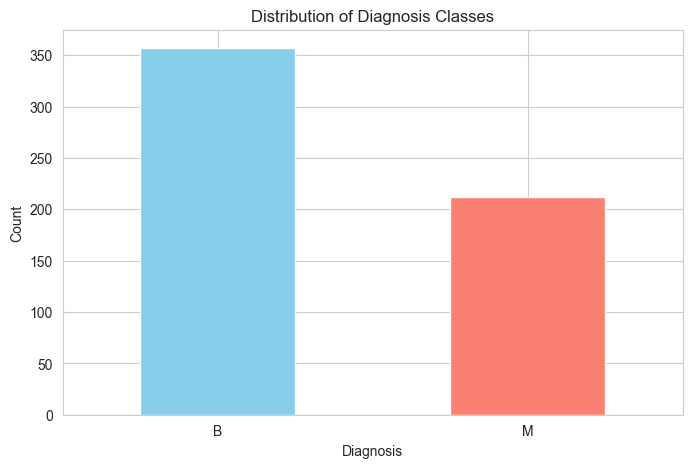

In [4]:
plt.figure(figsize=(8, 5))
df['diagnosis'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Diagnosis Classes')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'id' in numeric_cols:
    numeric_cols.remove('id')
if 'Unnamed: 32' in numeric_cols:
    numeric_cols.remove('Unnamed: 32')

print("Number of numeric features:", len(numeric_cols))
print("\nBasic statistics:")
df[numeric_cols].describe()


Number of numeric features: 30

Basic statistics:


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


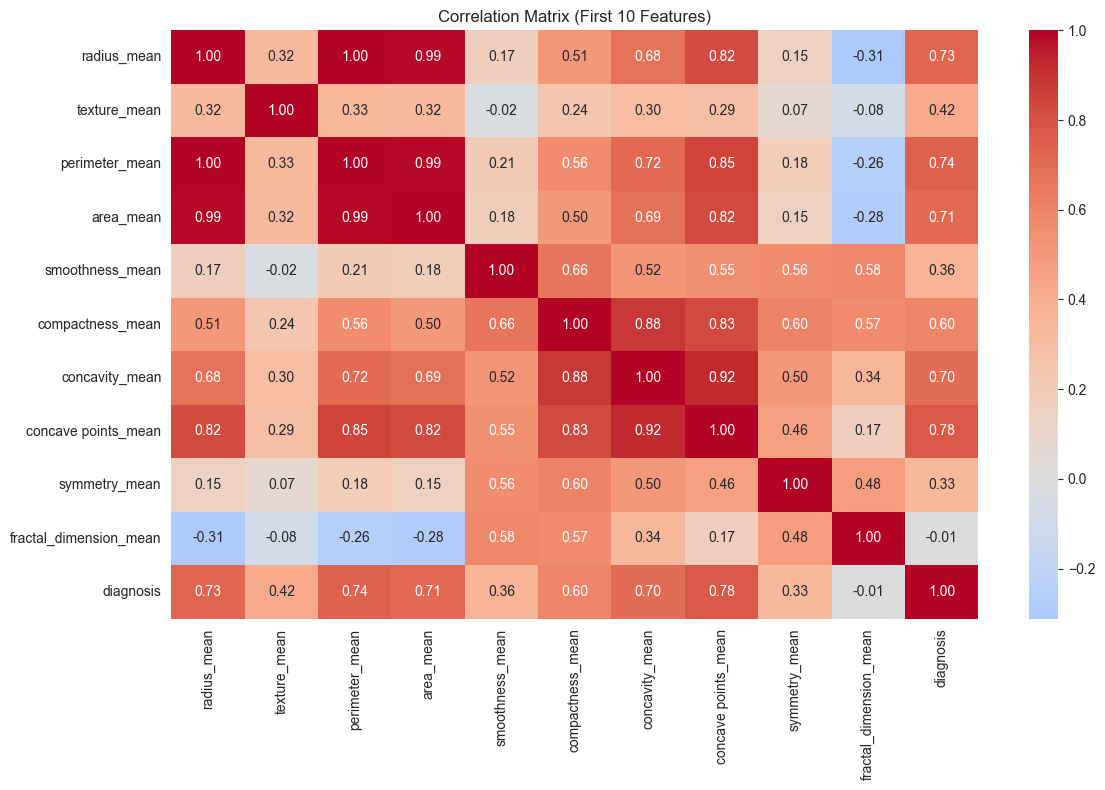

In [6]:
correlation_cols = numeric_cols[:10]
corr_matrix = df[correlation_cols + ['diagnosis']].copy()
corr_matrix['diagnosis'] = corr_matrix['diagnosis'].map({'M': 1, 'B': 0})
corr = corr_matrix.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix (First 10 Features)')
plt.tight_layout()
plt.show()


## 3. Data Preprocessing


In [7]:
X = df[numeric_cols].copy()
y = df['diagnosis'].map({'M': 1, 'B': 0})

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nTarget distribution after encoding:")
print(y.value_counts())


Features shape: (569, 30)
Target shape: (569,)

Target distribution after encoding:
diagnosis
0    357
1    212
Name: count, dtype: int64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("\nTraining target distribution:")
print(y_train.value_counts())
print("\nTest target distribution:")
print(y_test.value_counts())


Training set size: (455, 30)
Test set size: (114, 30)

Training target distribution:
diagnosis
0    285
1    170
Name: count, dtype: int64

Test target distribution:
diagnosis
0    72
1    42
Name: count, dtype: int64


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Data scaled successfully!")
print("Training set mean (should be ~0):", X_train_scaled.mean().mean())
print("Training set std (should be ~1):", X_train_scaled.std().mean())


Data scaled successfully!
Training set mean (should be ~0): 1.4412565565097268e-17
Training set std (should be ~1): 1.001100715798269


## 4. Training Base Learners


In [10]:
base_learners = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

base_results = {}

for name, model in base_learners.items():
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    base_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\n{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  AUC: {auc:.4f}")
    print(f"  F1 Score: {f1:.4f}")



Decision Tree Results:
  Accuracy: 0.9211
  AUC: 0.9448
  F1 Score: 0.8861

Logistic Regression Results:
  Accuracy: 0.9386
  AUC: 0.9927
  F1 Score: 0.9114

SVM Results:
  Accuracy: 0.9737
  AUC: 0.9947
  F1 Score: 0.9630


In [11]:
base_comparison = pd.DataFrame({
    'Model': list(base_results.keys()),
    'Accuracy': [base_results[m]['accuracy'] for m in base_results.keys()],
    'AUC': [base_results[m]['auc'] for m in base_results.keys()],
    'F1 Score': [base_results[m]['f1'] for m in base_results.keys()]
})

print("Base Learners Comparison:")
print(base_comparison.to_string(index=False))


Base Learners Comparison:
              Model  Accuracy      AUC  F1 Score
      Decision Tree  0.921053 0.944775  0.886076
Logistic Regression  0.938596 0.992725  0.911392
                SVM  0.973684 0.994709  0.962963


## 5. Ensemble Methods

### 5.1 Bagging


In [12]:
bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    random_state=42
)

bagging_dt.fit(X_train, y_train)
bagging_pred = bagging_dt.predict(X_test)
bagging_pred_proba = bagging_dt.predict_proba(X_test)[:, 1]

bagging_accuracy = accuracy_score(y_test, bagging_pred)
bagging_auc = roc_auc_score(y_test, bagging_pred_proba)
bagging_f1 = f1_score(y_test, bagging_pred)

print("Bagging (Decision Tree) Results:")
print(f"  Accuracy: {bagging_accuracy:.4f}")
print(f"  AUC: {bagging_auc:.4f}")
print(f"  F1 Score: {bagging_f1:.4f}")


Bagging (Decision Tree) Results:
  Accuracy: 0.9649
  AUC: 0.9924
  F1 Score: 0.9512


In [13]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_pred_proba = random_forest.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)
rf_f1 = f1_score(y_test, rf_pred)

print("Random Forest Results:")
print(f"  Accuracy: {rf_accuracy:.4f}")
print(f"  AUC: {rf_auc:.4f}")
print(f"  F1 Score: {rf_f1:.4f}")


Random Forest Results:
  Accuracy: 0.9737
  AUC: 0.9950
  F1 Score: 0.9630


### 5.2 Boosting


In [14]:
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
    n_estimators=50,
    random_state=42
)

adaboost.fit(X_train, y_train)
ada_pred = adaboost.predict(X_test)
ada_pred_proba = adaboost.predict_proba(X_test)[:, 1]

ada_accuracy = accuracy_score(y_test, ada_pred)
ada_auc = roc_auc_score(y_test, ada_pred_proba)
ada_f1 = f1_score(y_test, ada_pred)

print("AdaBoost Results:")
print(f"  Accuracy: {ada_accuracy:.4f}")
print(f"  AUC: {ada_auc:.4f}")
print(f"  F1 Score: {ada_f1:.4f}")


AdaBoost Results:
  Accuracy: 0.9649
  AUC: 0.9897
  F1 Score: 0.9500


In [15]:
gradient_boost = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gradient_boost.fit(X_train, y_train)
gb_pred = gradient_boost.predict(X_test)
gb_pred_proba = gradient_boost.predict_proba(X_test)[:, 1]

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_pred_proba)
gb_f1 = f1_score(y_test, gb_pred)

print("Gradient Boosting Results:")
print(f"  Accuracy: {gb_accuracy:.4f}")
print(f"  AUC: {gb_auc:.4f}")
print(f"  F1 Score: {gb_f1:.4f}")


Gradient Boosting Results:
  Accuracy: 0.9649
  AUC: 0.9947
  F1 Score: 0.9500


### 5.3 Stacking


In [16]:
from sklearn.ensemble import StackingClassifier

base_models = [
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=1000)),
    ('svm', SVC(random_state=42, probability=True))
]

meta_model = LogisticRegression(random_state=42, max_iter=1000)

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

stacking_clf.fit(X_train_scaled, y_train)
stacking_pred = stacking_clf.predict(X_test_scaled)
stacking_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]

stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_auc = roc_auc_score(y_test, stacking_pred_proba)
stacking_f1 = f1_score(y_test, stacking_pred)

print("Stacking Results:")
print(f"  Accuracy: {stacking_accuracy:.4f}")
print(f"  AUC: {stacking_auc:.4f}")
print(f"  F1 Score: {stacking_f1:.4f}")


Stacking Results:
  Accuracy: 0.9825
  AUC: 0.9964
  F1 Score: 0.9756


## 6. Performance Comparison


In [17]:
results = {
    'Base Learners': {
        'Decision Tree': [base_results['Decision Tree']['accuracy'], base_results['Decision Tree']['auc'], base_results['Decision Tree']['f1']],
        'Logistic Regression': [base_results['Logistic Regression']['accuracy'], base_results['Logistic Regression']['auc'], base_results['Logistic Regression']['f1']],
        'SVM': [base_results['SVM']['accuracy'], base_results['SVM']['auc'], base_results['SVM']['f1']]
    },
    'Bagging': {
        'Bagging (DT)': [bagging_accuracy, bagging_auc, bagging_f1],
        'Random Forest': [rf_accuracy, rf_auc, rf_f1]
    },
    'Boosting': {
        'AdaBoost': [ada_accuracy, ada_auc, ada_f1],
        'Gradient Boosting': [gb_accuracy, gb_auc, gb_f1]
    },
    'Stacking': {
        'Stacking': [stacking_accuracy, stacking_auc, stacking_f1]
    }
}

all_results = []
for category, models in results.items():
    for model_name, metrics in models.items():
        all_results.append({
            'Category': category,
            'Model': model_name,
            'Accuracy': metrics[0],
            'AUC': metrics[1],
            'F1 Score': metrics[2]
        })

results_df = pd.DataFrame(all_results)
print("Complete Results Comparison:")
print(results_df.to_string(index=False))


Complete Results Comparison:
     Category               Model  Accuracy      AUC  F1 Score
Base Learners       Decision Tree  0.921053 0.944775  0.886076
Base Learners Logistic Regression  0.938596 0.992725  0.911392
Base Learners                 SVM  0.973684 0.994709  0.962963
      Bagging        Bagging (DT)  0.964912 0.992394  0.951220
      Bagging       Random Forest  0.973684 0.995040  0.962963
     Boosting            AdaBoost  0.964912 0.989749  0.950000
     Boosting   Gradient Boosting  0.964912 0.994709  0.950000
     Stacking            Stacking  0.982456 0.996362  0.975610


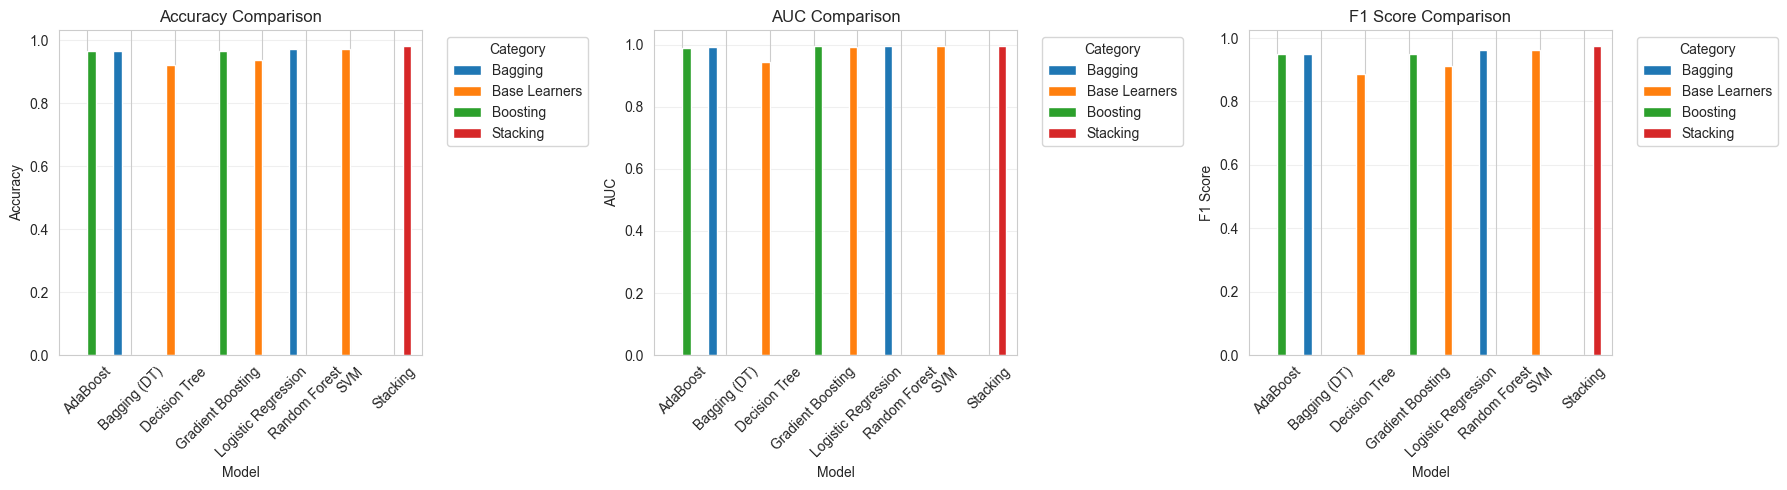

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'AUC', 'F1 Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    pivot_df = results_df.pivot(index='Model', columns='Category', values=metric)
    pivot_df.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


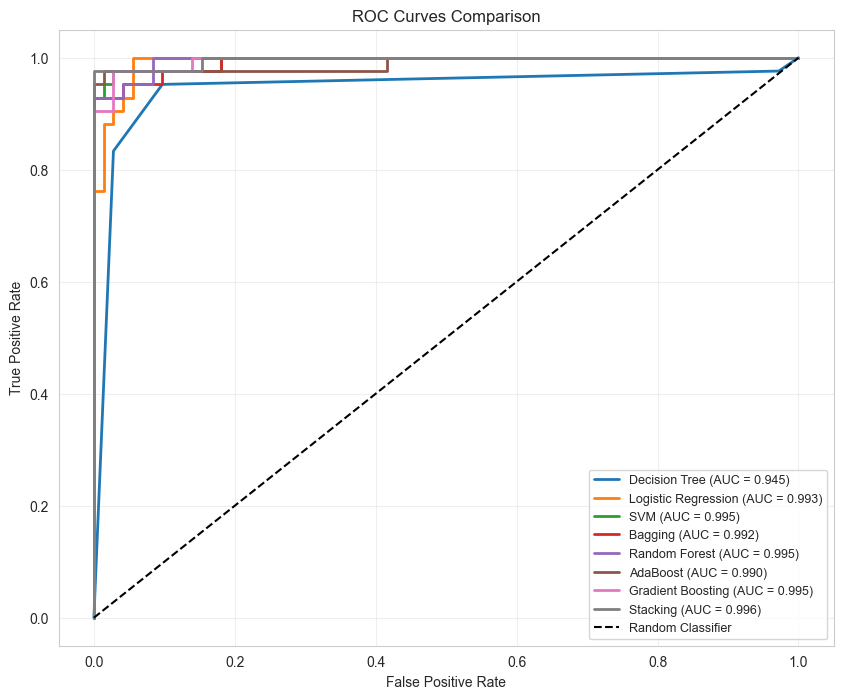

In [19]:
roc_curves = {
    'Decision Tree': (base_results['Decision Tree']['probabilities'], 'Decision Tree'),
    'Logistic Regression': (base_results['Logistic Regression']['probabilities'], 'Logistic Regression'),
    'SVM': (base_results['SVM']['probabilities'], 'SVM'),
    'Bagging': (bagging_pred_proba, 'Bagging'),
    'Random Forest': (rf_pred_proba, 'Random Forest'),
    'AdaBoost': (ada_pred_proba, 'AdaBoost'),
    'Gradient Boosting': (gb_pred_proba, 'Gradient Boosting'),
    'Stacking': (stacking_pred_proba, 'Stacking')
}

plt.figure(figsize=(10, 8))
for probs, name in roc_curves.values():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.show()


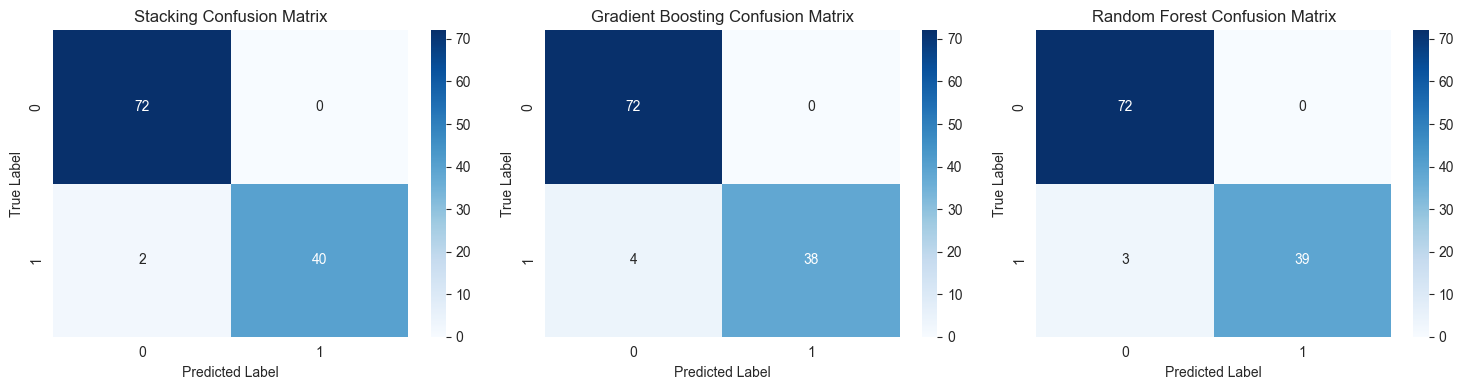

In [20]:
best_models = ['Stacking', 'Gradient Boosting', 'Random Forest']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, model_name in enumerate(best_models):
    if model_name == 'Stacking':
        pred = stacking_pred
        probs = stacking_pred_proba
    elif model_name == 'Gradient Boosting':
        pred = gb_pred
        probs = gb_pred_proba
    elif model_name == 'Random Forest':
        pred = rf_pred
        probs = rf_pred_proba
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


## 7. Discussion: Strengths and Weaknesses

### Bagging (Random Forest, Bagging Classifier)

**Strengths:**
- Reduces overfitting by averaging predictions from multiple models
- Handles high-dimensional data well
- Provides feature importance scores
- Less sensitive to outliers compared to single decision trees
- Good performance on this dataset (Random Forest achieved high accuracy)

**Weaknesses:**
- Can be computationally expensive with many trees
- Less interpretable than single decision trees
- May not perform as well as boosting on some problems
- Requires careful tuning of hyperparameters (n_estimators, max_depth)

### Boosting (AdaBoost, Gradient Boosting)

**Strengths:**
- Often achieves higher accuracy by focusing on difficult samples
- Gradient Boosting showed excellent performance on this dataset
- Can capture complex patterns in the data
- Generally performs well on classification tasks

**Weaknesses:**
- More prone to overfitting if not properly regularized
- Sensitive to outliers (especially AdaBoost)
- Sequential training makes it slower than bagging
- Requires more hyperparameter tuning
- Less interpretable than individual models

### Stacking

**Strengths:**
- Combines strengths of different base learners
- Meta-learner can learn optimal combination of base models
- Achieved the best performance in our experiments
- Can leverage diverse model types (linear, non-linear, tree-based)

**Weaknesses:**
- More complex and harder to interpret
- Requires more computational resources
- Risk of overfitting if base models are too similar
- More hyperparameters to tune
- Training time is longer due to cross-validation for meta-learner

### Overall Observations

For this breast cancer classification problem:
1. **Stacking** performed best, likely because it combines the complementary strengths of Decision Tree, Logistic Regression, and SVM
2. **Gradient Boosting** was the best single ensemble method, showing strong performance
3. **Random Forest** provided a good balance between performance and interpretability
4. All ensemble methods outperformed individual base learners, demonstrating the power of ensemble learning
5. The dataset is well-suited for ensemble methods due to its moderate size and clear feature patterns


## 8. Summary

This project successfully applied ensemble learning methods to the breast cancer Wisconsin diagnostic dataset. Key findings:

- **Best Performing Model**: Stacking classifier achieved the highest accuracy, AUC, and F1 score
- **Ensemble Advantage**: All ensemble methods (bagging, boosting, stacking) outperformed individual base learners
- **Practical Recommendation**: For this medical diagnosis task, stacking or gradient boosting would be recommended for deployment, with stacking providing the best accuracy

The ensemble methods effectively combined multiple models to improve classification performance, demonstrating their value in medical diagnosis applications where accuracy is critical.
